In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import os
os.makedirs("../out", exist_ok=True)

from tqdm import tqdm

## Q1.2: Lucas-Kanade Tracking

Make sure to comment your code and use proper names for your variables. 

In [2]:
# We recommend using this function, but you can explore other methods as well (e.g., ndimage.shift).
from scipy.interpolate import RectBivariateSpline

# The function below could be useful as well :) 
#from numpy.linalg import lstsq

def LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2)):
    """
    :param[np.array(H, W)] It   : Image frame at time-step t
    :param[np.array(H, W)] It1  : Image frame at time-step t+1
    :param[np.array(4, 1)] rect : Coordinates of template which has the form [x1, y1, x2, y2], where
                                  [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[float] dp_thresh     : If the length of dp < threshold, terminate the optimization
    :param[int] num_iters       : Number of iterations for running the optimization
    :param[np.array(2, 1)] p0   : Initial movement vector [dp_x0, dp_y0]

    :return[np.array(2, 1)] p   : Final movement vector [dp_x, dp_y]
    """
	
    # Initialize p to p0. Don't remove these lines.
    p = p0
    delta_p = np.ones((1,2))

    # ----------------------------------------------------------------------------------------------
    # TODO: Add your LK implementation here: 
    x1 = rect[0]
    y1 = rect[1]
    x2 = rect[2]
    y2 = rect[3]
    
    # shift for It and It1 to get It_rec, It1_rec for future .ev()
    h_t,w_t = np.shape(It)
    y_wrap, x_wrap = np.meshgrid(np.linspace(0, h_t, h_t, endpoint = False), np.linspace(0, w_t, w_t, endpoint = False))
    It_wrap = RectBivariateSpline(y_wrap[0,:], x_wrap[:, 0], It)
    
    h_1, w_1 = np.shape(It1)
    y1_wrap, x1_wrap = np.meshgrid(np.linspace(0, h_1, h_1, endpoint = False), np.linspace(0, w_1, w_1, endpoint = False))
    It1_rec = RectBivariateSpline(y1_wrap[0,:], x1_wrap[:, 0], It1)
    
    # Get the index of the template pixel
    y_pos, x_pos = np.meshgrid(np.linspace(y1, y2+1, int(y2-y1)),np.linspace(x1, x2+1, int(x2-x1)))

    # Get the template T(x) from It, it remains the same in the optimization process
    Template = It_wrap.ev(y_pos, x_pos).flatten()
    
    dp = np.linalg.norm(delta_p)
    
#     # Used for debugging
#     count = 0
#     norm_values = []
    
    for i in range(0, num_iters):
        # x' = x + p
        x_prime = x_pos + p[0]
        y_prime = y_pos + p[1]
        
        # wrap It1(x')
        It1_wrap = It1_rec.ev(y_prime, x_prime).flatten()
        
        # Build linear system: A,b:
        b = Template - It1_wrap
        
        #Jacobian_W = np.eye(2)
        
        # sample the img gradient at x'
        gIx = It1_rec.ev(y_prime, x_prime, dy=1).flatten()
        gIy = It1_rec.ev(y_prime, x_prime, dx=1).flatten()
#         print("dx: ", gIx)
#         print("dy: ", gIy)

        A = np.column_stack((gIx, gIy))
#         print("A is ", A)
#         print("b is ", b)
        
        # Run least-squares optimization
        Hei = np.matmul(A.T, A) # A^T*A
        delta_p = np.linalg.pinv(Hei)@ A.T @ b
#         delta_p = np.linalg.lstsq(A, b,rcond=None)[0].T[0]
   
        # store the norm of deltea_p for debugging
        dp = np.linalg.norm(delta_p)
        if(dp < threshold):
            break
#         norm_values.append(dp)
#         count += 1

        # Update the local motion
        p = p + delta_p
#         print(p)

    # plot the norm values versus iteration number
#     plt.plot(range(1, count+1), norm_values, 'bo-')
#     plt.xlabel('Iteration')
#     plt.ylabel('Norm of delta_p')
#     plt.title('Norm of delta_p versus iteration')
#     plt.show()

    # ----------------------------------------------------------------------------------------------
    return p

### Debug Q1.2 

A few tips to debug your implementation:
- You can use the short snippet of code below to test if you get reasonable results. The snippet simply 
checks visualizes the resulting p from running LK on a single frame. You should be able to see a slight shift in the template. 

- You may also want to visualize the image gradients you compute within your LK implementation

- Plot iterations vs the norm of delta_p

86 35


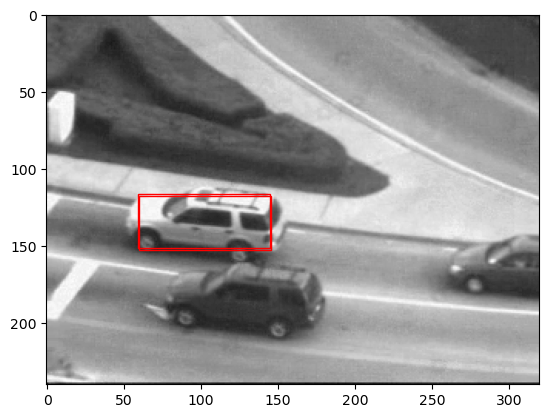

In [3]:
num_iters = 100
threshold = 0.01
seq = np.load("../data/carseq.npy")
rect = [59, 116, 145, 151]
It = seq[:,:,0]
w = rect[2] - rect[0]
h = rect[3] - rect[1]
print(w, h)

# Initial frame
plt.figure()
currentAxis = plt.gca()
rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
currentAxis.add_patch(rect_draw_It1)

# TODO: run LK and update template and plot 
# ----------------------------------------------------------------------------------------------
It1 = seq[:,:,1]
p = LucasKanade(It, It1, rect, threshold, num_iters, p0=np.zeros(2))
rect[0] += p[0]
rect[1] += p[1]
rect[2] += p[0]
rect[3] += p[1]
    
rect_draw_It1 = patches.Rectangle((rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')

currentAxis.add_patch(rect_draw_It1)
plt.imshow(It1, cmap='gray')
plt.show()

# ----------------------------------------------------------------------------------------------

## Q1.3: Track Sequence

In [4]:
def TrackSequence(seq, rect, num_iters, threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape

    rects =[rect]
#     It = seq[:, :, 0]
        
    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest. Add your code here:
    for i in tqdm(range(N-1)):
        It = seq[:, :, i]
        It1 = seq[:, :, i+1]
        p = LucasKanade(It, It1, rect, threshold, num_iters) 
#         print(i, " frame: ", p) 
        rect[0] += p[0]
        rect[1] += p[1]
        rect[2] += p[0]
        rect[3] += p[1]
        rects = np.vstack((rects, rect))
#         print(rect)

    # ----------------------------------------------------------------------------------------------
        
    rects = np.array(rects)
#     print("its shape" , rects) #415,4
    
    # Just a sanity check
    assert rects.shape == (N, 4), f"Your output sequence {rects.shape} is not {N}x{4}"
    return rects

### Q1.3: Track Car Sequence

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [ ]:
seq = np.load("../data/carseq.npy")

# TODO: update
rect = [59, 116, 145, 151]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = int(1e4)
threshold = 1e-2

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(f'../out/carseqrects.npy', rects)

 46%|██████████████████▉                      | 191/414 [00:07<00:07, 29.86it/s]

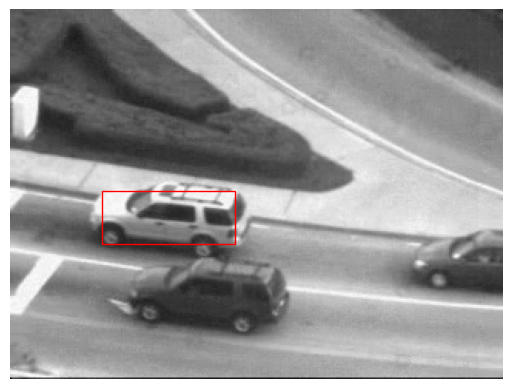

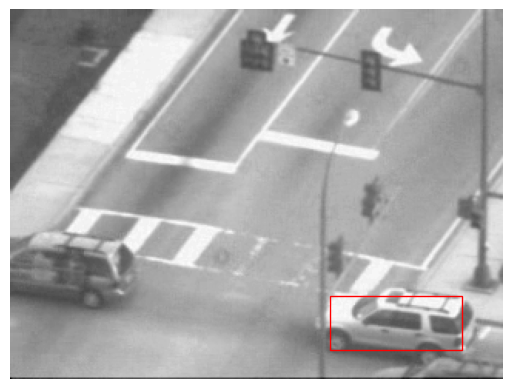

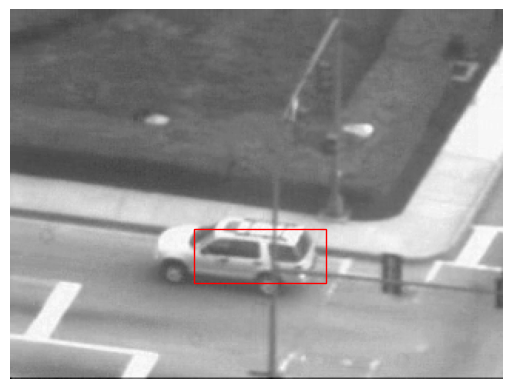

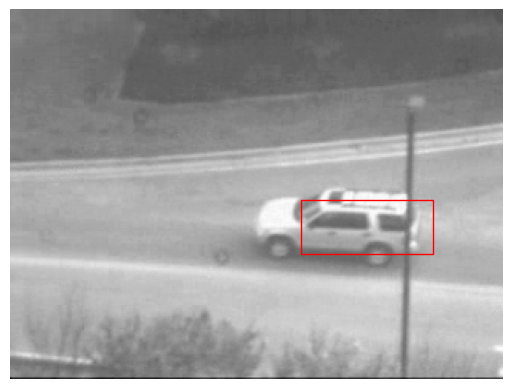

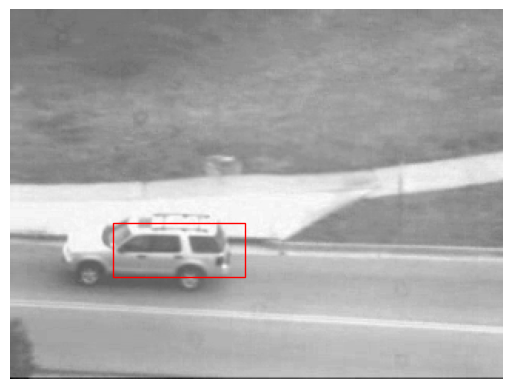

In [6]:
# TODO: visualize. You can make this into a function to re-use it for other visualization questions. 
# List of frames to save
frames_to_save = [1, 80, 160, 280, 410]

for idx in frames_to_save:
    frame = seq[:,:,idx]
    rect = rects[idx-1,:]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.3_carseq_{idx}.png")
    
    # NOTE: here's an example on how to visualize a frame with its template. 
    # frame = 
    # rect = 
    # w = 
    # h = 
    # plt.figure()
    # axis = plt.gca()
    # rect_draw = patches.Rectangle(
    #     (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # axis.add_patch(rect_draw)
    # plt.imshow(frame, cmap='gray')
    # plt.axis('off')
    # plt.savefig(f"../out/sol_1.3_carseq_{idx+1}.png")


### Q1.3: Test Girl Sequence

Same drill as with the car sequence. 

In [7]:
seq = np.load("../data/girlseq.npy")

# TODO: update
rect = [280, 152, 330, 318]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = int(1e6)
threshold = 1e-2

rects = TrackSequence(seq, rect, num_iters, threshold)
np.save(f'../out/girlseqrects.npy', rects)

100%|███████████████████████████████████████████| 89/89 [00:12<00:00,  7.19it/s]


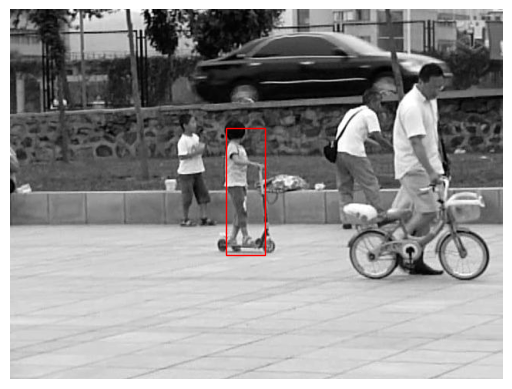

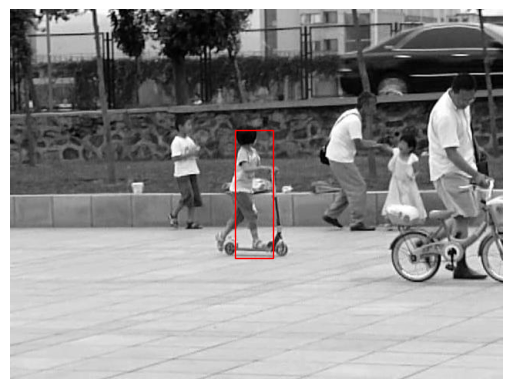

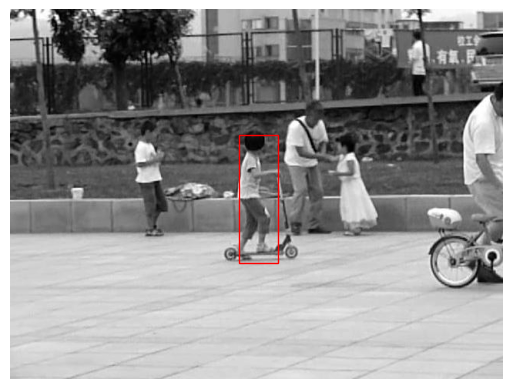

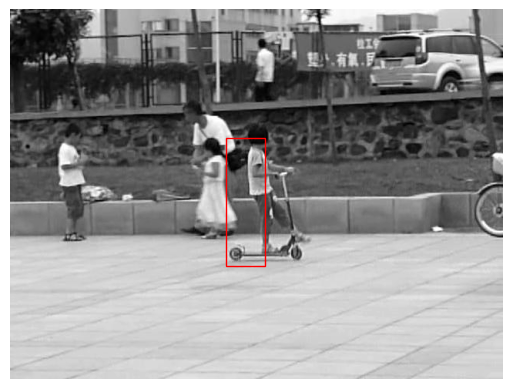

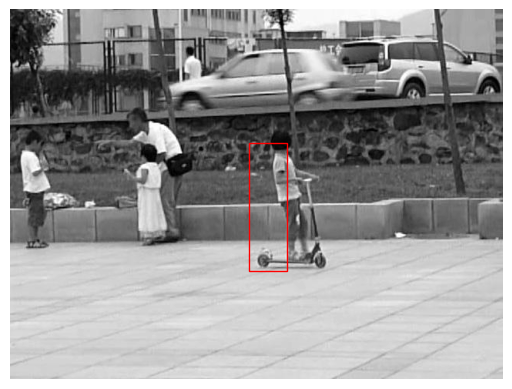

In [8]:
# TODO: visualize. You can copy-and-paste your visualization code from before (or re-use the function)
frames_to_save = [1, 15, 35, 65, 85]


for idx in frames_to_save:
    frame = seq[:,:,idx]
    rect = rects[idx-1,:]
    w = rect[2] - rect[0]
    h = rect[3] - rect[1]
    plt.figure()
    axis = plt.gca()
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    axis.add_patch(rect_draw)
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.3_girlseq_{idx}.png")
    
    # NOTE: here's an example on how to visualize a frame with its template. 
    # frame = 
    # rect = 
    # w = 
    # h = 
    # plt.figure()
    # axis = plt.gca()
    # rect_draw = patches.Rectangle(
    #     (rect[0], rect[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # axis.add_patch(rect_draw)
    # plt.imshow(frame, cmap='gray')
    # plt.axis('off')
    # plt.savefig(f"../out/sol_1.3_carseq_{idx+1}.png")

## Q1.4: Tracking with Template Correction 

In [9]:
def TrackSequenceWithTemplateCorrection(seq, rect_0, num_iters, lk_threshold, drift_threshold):
    """
    :param[np.array(H, W, N)] seq : sequence of frames
    :param[np.array(4, 1)] rect   : Coordinates of template which has the form [x1, y1, x2, y2], where
                                    [x1, y1] is the top-left, and [x2, y2] is the bottom-right corner.  
    :param[int] num_iters         : Number of iterations for running the optimization
    :param[float] dp_thresh       : If the length of dp < threshold, terminate the optimization
    :param[float] drift_threshold : float, threshold for the template update.

    :return[np.array(N, 4)] rects : Coordinates for the template at each frame in the sequence.
    """
    H, W, N = seq.shape
    rect = np.copy(rect_0)
    rects_wtcr =[rect]
    
    It = seq[:,:,0]
    It0 = seq[:,:,0]

    # ----------------------------------------------------------------------------------------------
    # TODO: Iterate over the sequence to track the object in of interest and do template correction.
    #  Add your code here:
    p0 = np.zeros(2)
    for i in tqdm(range(1, seq.shape[2])):
        It1 = seq[:, :, i]
        p = LucasKanade(It, It1, rect, lk_threshold, num_iters, p0)
        
        dx = rect[0] - rect_0[0]
        dy = rect[1] - rect_0[1]
        
        p_shift = p + [dx, dy]
        
        # running lk with I0 and It1 w/ original rect
        p_new = LucasKanade(It0, It1, rect_0, lk_threshold, num_iters, p_shift)
        
        dp = np.linalg.norm(p_new - p_shift)
        
        if(dp <= drift_threshold):
            p_update = (p_new - [dx, dy])
            rect[0] += p_update[0]
            rect[1] += p_update[1]
            rect[2] += p_update[0]
            rect[3] += p_update[1]
            It = seq[:, :, i]
            
            #update rects_wtcr
            rects_wtcr = np.vstack((rects_wtcr, rect))
            p0 = np.zeros(2)
        else:
            rects_wtcr = np.vstack((rects_wtcr, [rect[0]+p[0], rect[1]+p[1], rect[2]+p[0], rect[3]+p[1]]))
            p0 = p

    # ----------------------------------------------------------------------------------------------
    
    rects_wtcr = np.array(rects_wtcr)
    # Just a sanity check
    assert rects_wtcr.shape == (N, 4), f"Your output sequence {rects_wtcr.shape} is not {N}x{4}"
    return rects_wtcr

### Q1.4: Track Car Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [10]:
seq = np.load("../data/carseq.npy")

# TODO: update
rect = [59, 116, 145, 151]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = int(1e4)
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/carseqrects-wtcr.npy", rects)

100%|█████████████████████████████████████████| 414/414 [00:28<00:00, 14.50it/s]


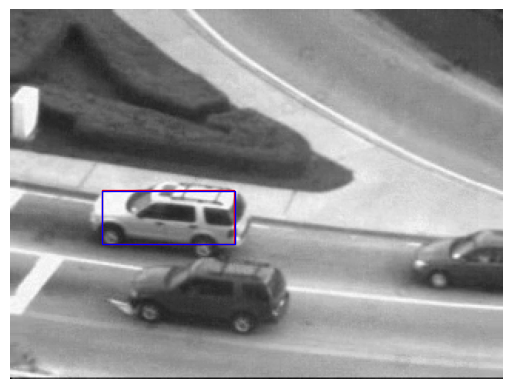

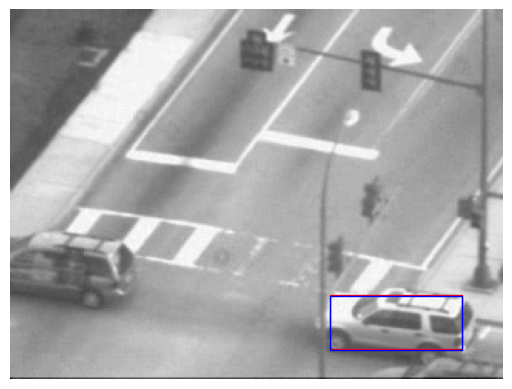

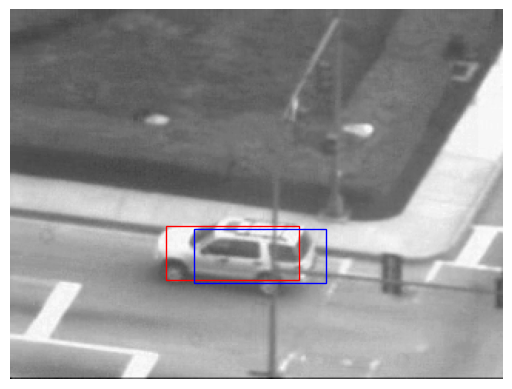

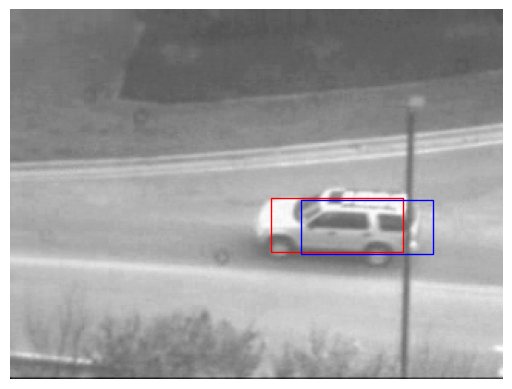

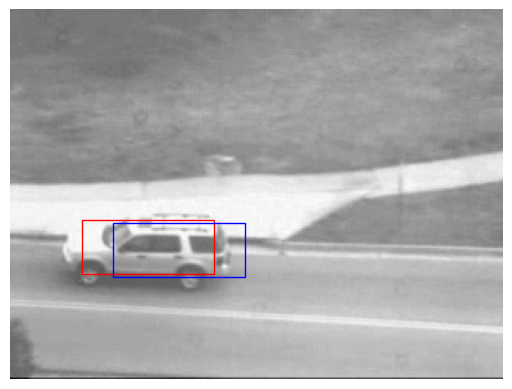

In [11]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
frames_to_save = [1, 80, 160, 280, 410]

rects_wtcr = np.load("../out/carseqrects-wtcr.npy")
rects = np.load("../out/carseqrects.npy")

for idx in frames_to_save:
    rect_wtcr = rects_wtcr[idx-1]
    rect = rects[idx-1]
    frame = seq[:, :, idx]
    
    w = rect_wtcr[2] - rect_wtcr[0]
    h = rect_wtcr[3] - rect_wtcr[1]

    plt.figure()
    currentAxis = plt.gca()
    rect_wcrt_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wcrt_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), rect[2] - rect[0], rect[3] - rect[1], linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.4_carseq_{idx}.png")
    
    # rect_wtcr = 
    # rect = 
    # frame = 

    # plt.figure()
    # currentAxis = plt.gca()
    # rect_wcrt_draw = patches.Rectangle(
    #     (rect_wcrt[0], rect_wcrt[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # currentAxis.add_patch(rect_wcrt_draw)
    
    # rect_draw = patches.Rectangle(
    #     (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    # currentAxis.add_patch(rect_draw)
    
    # plt.imshow(frame, cmap='gray')
    # plt.axis('off')
    # plt.savefig(f"../out/sol_1.4_carseq_{idx+1}.png")

### Q1.4: Track Girl Sequence with Template Correction

Feel free to play with these snippets of code; run ablations, visualize a gif with the whole sequence, etc.

Just make sure the bounding boxes for the car are clearly visible, and report those of the frames we requested. 

In [12]:
seq = np.load("../data/girlseq.npy")

# TODO: update
rect = [280, 152, 330, 318]

# NOTE: these are default parameters. Once your code works, you're encouraged to play with them by
# running ablations, and report your best results. 
num_iters = int(1e4)
threshold = 1e-2
drift_threshold = 5

rects = TrackSequenceWithTemplateCorrection(seq, rect, num_iters, threshold, drift_threshold)
np.save("../out/girlseqrects-wtcr.npy", rects)

100%|███████████████████████████████████████████| 89/89 [01:57<00:00,  1.32s/it]


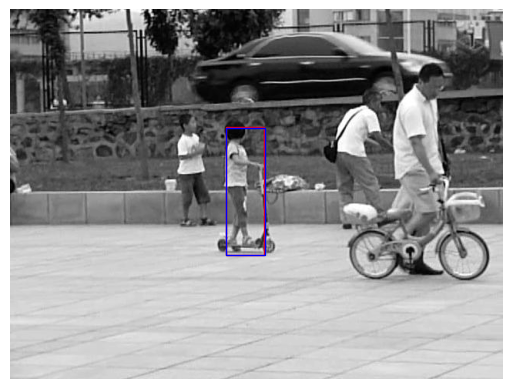

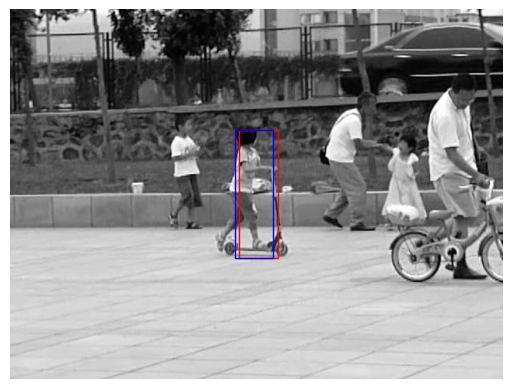

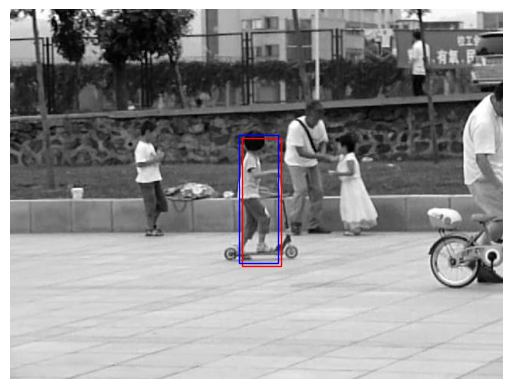

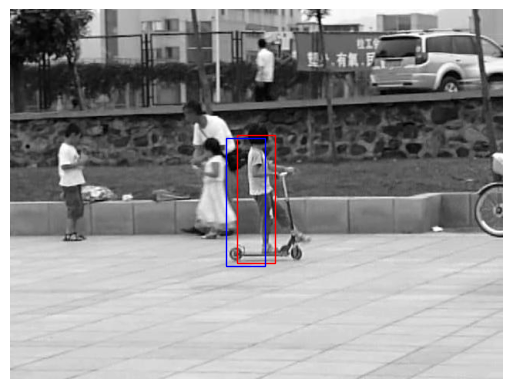

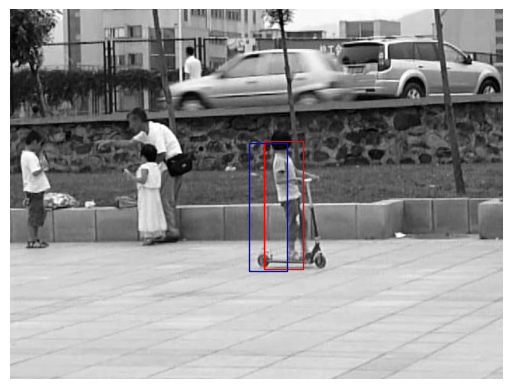

In [13]:
# TODO: visualize. An example for how to visualize the outputs
# List of frames to visualize
frames_to_save = [1, 15, 35, 65, 85]

rects_wtcr = np.load("../out/girlseqrects-wtcr.npy")
rects = np.load("../out/girlseqrects.npy")

for idx in frames_to_save:
    rect_wtcr = rects_wtcr[idx-1]
    rect = rects[idx-1]
    frame = seq[:, :, idx]
    
    w = rect_wtcr[2] - rect_wtcr[0]
    h = rect_wtcr[3] - rect_wtcr[1]

    plt.figure()
    currentAxis = plt.gca()
    rect_wcrt_draw = patches.Rectangle(
        (rect_wtcr[0], rect_wtcr[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    currentAxis.add_patch(rect_wcrt_draw)
    
    rect_draw = patches.Rectangle(
        (rect[0], rect[1]), rect[2] - rect[0], rect[3] - rect[1], linewidth=1, edgecolor='b', facecolor='none')
    currentAxis.add_patch(rect_draw)
    
    plt.imshow(frame, cmap='gray')
    plt.axis('off')
    plt.savefig(f"../out/sol_1.4_girlseq_{idx}.png")
    
    # rect_wtcr = 
    # rect = 
    # frame = 

    # plt.figure()
    # currentAxis = plt.gca()
    # rect_wcrt_draw = patches.Rectangle(
    #     (rect_wcrt[0], rect_wcrt[1]), w, h, linewidth=1, edgecolor='r', facecolor='none')
    # currentAxis.add_patch(rect_wcrt_draw)
    
    # rect_draw = patches.Rectangle(
    #     (rect[0], rect[1]), w, h, linewidth=1, edgecolor='b', facecolor='none')
    # currentAxis.add_patch(rect_draw)
    
    # plt.imshow(frame, cmap='gray')
    # plt.axis('off')
    # plt.savefig(f"../out/sol_1.4_girlseq_{idx+1}.png")